In [119]:
# initial imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from invdistweightedknn import KnnRegression
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from math import sqrt, log1p

In [120]:
# Import data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [121]:
train = train.drop(train[(train['GrLivArea']>4500)].index)
train = train.drop(train[(train['TotalBsmtSF']>=4000)].index)

In [122]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
data = pd.concat((train, test)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)
print("Concatenated data size is : {}".format(data.shape))

Concatenated data size is : (2917, 80)


In [123]:
# Replacing missing value with None for appropiate columns acc to data description
data["PoolQC"] = data["PoolQC"].fillna("None")
data["MiscFeature"] = data["MiscFeature"].fillna("None")
data["Alley"] = data["Alley"].fillna("None")
data["Fence"] = data["Fence"].fillna("None")
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data['MSSubClass'] = data['MSSubClass'].fillna("None")
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col] = data[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
    
# Replacing missing value with 0 for appropiate columns acc to data description
for col in ('GarageYrBlt', 'GarageCars'):
    data[col] = data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

data["LotFrontage"] = data["LotFrontage"].fillna(data['LotFrontage'].mean())
data["GarageArea"] = data["GarageArea"].fillna(data['GarageArea'].mean())

# Replacing missing value with most common value for appropiate columns acc to data description
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
for col in ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    data[col] = data[col].fillna(data[col].mode()[0])
data["Functional"] = data["Functional"].fillna("Typ")

# Dropping column
data = data.drop(['Utilities'], axis=1)

In [124]:
selected_cols = ['OverallQual','GrLivArea','GarageCars','TotalBsmtSF',
                                 '1stFlrSF','GarageArea','BsmtFinSF1','2ndFlrSF']
data = data[selected_cols]

In [125]:
n_folds = 5

def knn_rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [126]:
ind = []
for i in range(2, 10):
    for p in range(1, 10):
        ind.append(str(i) + '|' + str(p))

In [127]:
# train["SalePrice"] = np.log1p(train["SalePrice"])

In [128]:
from sklearn import preprocessing
col_names = data.columns
x = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_2 = pd.DataFrame(x_scaled)

In [129]:
data_2

,0,1,2,3,4,5,6,7
0,0.666667,0.289015,0.4,0.168008,0.109641,0.368280,0.176060,0.413559
1,0.555556,0.194917,0.4,0.247694,0.194917,0.309140,0.243890,0.000000
2,0.666667,0.304978,0.4,0.180569,0.123083,0.408602,0.121197,0.419370
3,0.666667,0.290485,0.6,0.148381,0.131695,0.431452,0.053865,0.366102
4,0.777778,0.391514,0.6,0.224730,0.170342,0.561828,0.163342,0.509927
5,0.444444,0.215921,0.4,0.156232,0.097038,0.322581,0.182544,0.274092
6,0.777778,0.285654,0.4,0.330913,0.285654,0.427419,0.341397,0.000000
7,0.666667,0.368830,0.4,0.217272,0.162361,0.325269,0.214214,0.476029
8,0.666667,0.302457,0.4,0.186850,0.144507,0.314516,0.000000,0.364165
9,0.444444,0.156060,0.2,0.194504,0.156060,0.137769,0.212219,0.000000


In [130]:
knn_acc = []
knn_acc_2 = []

X_train, X_test, y_train, y_test = train_test_split(data[:ntrain], train.SalePrice.values, test_size=0.2)

# X_cols = ["LotArea", "YearBuilt", "OverallQual"]
# X_train = X_train[X_cols]
# X_test = X_test[X_cols]
scale = preprocessing.MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)
for k in range(2, 10):
    knn_acc_1 = []
    for p in range(1, 10):
        clf = KnnRegression(k=k, p=p)
        clf.fit(X_train, y_train)
        knn_pred = []
        for x in X_test:
            pred = clf.predict(x)
            knn_pred.append(pred)
        knn_target_pred = np.array(knn_pred)
        knn_acc.append(sqrt(mean_squared_error(y_test, knn_target_pred)))
        knn_acc_1.append(sqrt(mean_squared_error(y_test, knn_target_pred)))
    knn_acc_2.append(knn_acc_1)

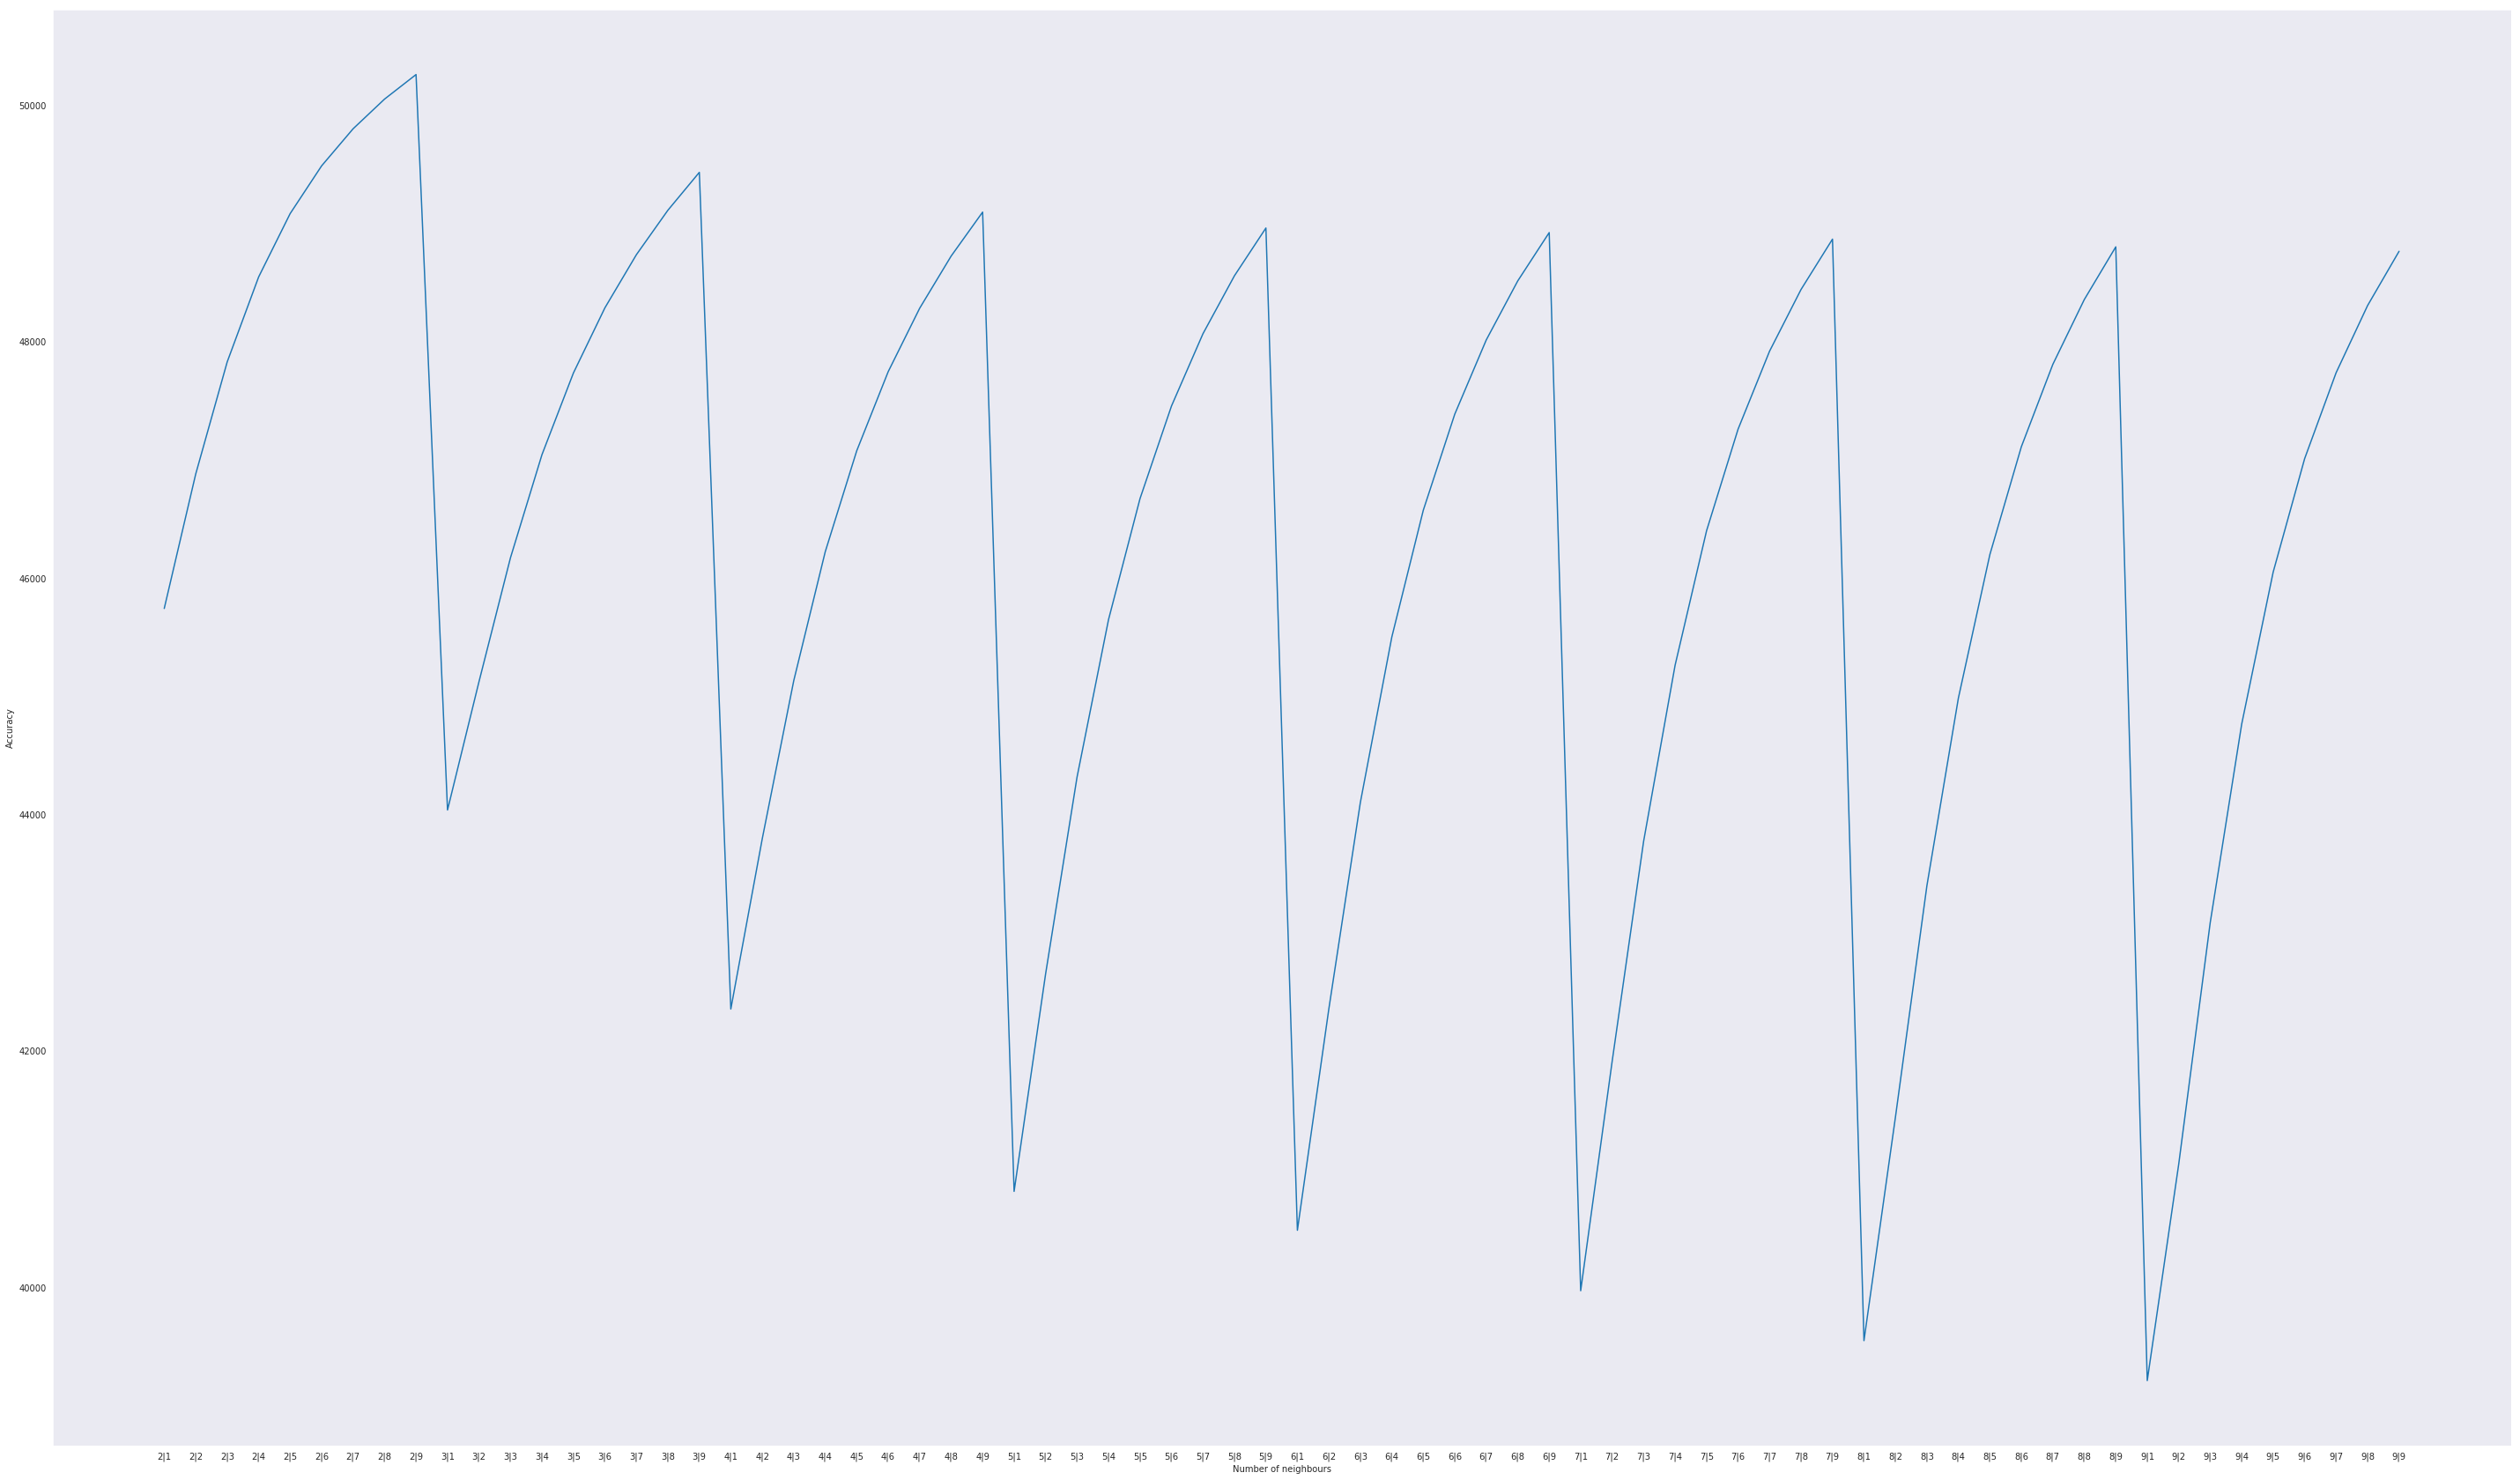

In [131]:
plt.figure(figsize=(50,30))
plt.plot(ind, knn_acc)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')

plt.grid()
plt.show()

In [139]:
X_train, X_test, y_train, y_test = train_test_split(data[:ntrain], train.SalePrice.values, test_size=0.2)

scale = preprocessing.MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

clf = KnnRegression(k=9, p=1)
clf.fit(X_train, y_train)
knn_pred = []
for x in X_test:
    pred = clf.predict(x)
    knn_pred.append(pred)
knn_test_pred = np.array(knn_pred)

print (X_train.shape, y_train.shape, X_test.shape)
print (sqrt(mean_squared_error(np.log1p(y_test), np.log1p(knn_test_pred))))

(1166, 8) (1166,) (292, 8)
0.18822592361987087


In [147]:
clf = KnnRegression(k=9, p=1)
X_train = data[:ntrain]
y_train = train.SalePrice.values

X_test = data[ntrain:]

X_test = scale.fit_transform(X_test)
X_train = scale.fit_transform(X_train)

clf.fit(X_train, y_train)
prd = []
for x in X_test:
    pred = clf.predict(x)
    prd.append(pred)
preds = np.array(prd)

In [148]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("knninvdistk9p1selectedfeatures.csv", index = False)

In [149]:
solution

,id,SalePrice
0,1461,107877.447313
1,1462,138957.705134
2,1463,155843.877845
3,1464,163255.423622
4,1465,164460.373114
5,1466,166991.086038
6,1467,142908.617980
7,1468,168574.514362
8,1469,141644.544754
9,1470,113298.968874
